# My First Notebook

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

In [11]:
file_path = "C:\\Users\\kimdo\\Desktop\\Everything 24\\VS Code Files\\Datathon2024\\archive\\sd254_users.csv"
df_users = pd.read_csv(file_path)

In [12]:
df_trans = pd.read_csv("C:\\Users\\kimdo\\Desktop\\Everything 24\\VS Code Files\\Datathon2024\\archive\\credit_card_transactions-ibm_v2.csv")

In [13]:
unique_Users = df_trans['User'].unique()
selected_cards = pd.Series(unique_Users).sample(frac=0.4, replace=False, random_state=42)
filtered_transactions = df_trans[df_trans['User'].isin(selected_cards)]
df = filtered_transactions.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 1.2+ GB


In [14]:
df['Amount'] = df['Amount'].str.replace('$','').astype(float)
df['Hour'] = df['Time'].str[0:2]
df['Minute'] = df['Time'].str[3:5]
df = df.drop(['Time'], axis=1)
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
28882,2,0,2009,9,26,948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,0,01,56
28883,2,0,2009,10,1,42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,13
28884,2,0,2009,10,1,9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,0,10,49
28885,2,0,2009,10,1,36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,14,30
28886,2,0,2009,10,2,56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,25


In [18]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]



columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant City', 'Is Fraud?']
df = df[columns_to_select]

In [19]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

#Decreasing the number of categorical variables of 'Merchant City'. 

cities_to_keep = ['ONLINE', 'Rome', 'Algiers', 'Port au Prince', 'Strasburg', 'Istanbul', 'Mexico City', 'Abuja']
df['Merchant City'] = df['Merchant City'].apply(lambda city: city if city in cities_to_keep else 'others')


from sklearn.preprocessing import StandardScaler, OneHotEncoder

def clean(df):
    # Convert data type for 'Hour' column to float
    if 'Hour' in df.columns:
        df['Hour'] = df['Hour'].astype('float')
    
    # Scale the 'Amount' column
    if 'Amount' in df.columns:
        scaler = StandardScaler()
        df['Amount'] = scaler.fit_transform(df[['Amount']])
    
    # One-hot encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week', 'Merchant City', 'MCC']
    ohe = OneHotEncoder(sparse_output=False, drop=None)  # No dropping of categories
    
    for col in cat_col:
        if col in df.columns:
            # Fit and transform the categorical column using OneHotEncoder
            enc_df = pd.DataFrame(ohe.fit_transform(df[[col]]), 
                                  columns=ohe.get_feature_names_out([col]), 
                                  dtype='int8')
            
            # Ensure that the indices align before concatenating
            enc_df.index = df.index
            
            # Concatenate the new encoded columns with the original DataFrame
            df = pd.concat([df, enc_df], axis=1)
            
            # Drop the original categorical column
            df.drop([col], axis=1, inplace=True)
    
    # Convert all columns to float to ensure uniform type
    for col in df.columns:
        df[col] = df[col].astype(float)
    
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

C:\Users\kimdo\AppData\Local\Temp\ipykernel_8736\359827318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Merchant City'] = df['Merchant City'].apply(lambda city: city if city in cities_to_keep else 'others')
C:\Users\kimdo\AppData\Local\Temp\ipykernel_8736\359827318.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('float')
C:\Users\kimdo\AppData\Local\Temp\ipykernel_8736\359827318.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=   9.1s


In [20]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values for 'k'

# Train the KNN model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9231666666666667
Confusion Matrix:
 [[9192  416]
 [ 506 1886]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      9608
         1.0       0.82      0.79      0.80      2392

    accuracy                           0.92     12000
   macro avg       0.88      0.87      0.88     12000
weighted avg       0.92      0.92      0.92     12000



In [22]:
from sklearn.model_selection import GridSearchCV

# Set up a parameter grid to tune the number of neighbors
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'n_neighbors': 9}
Best Cross-Validation Accuracy: 0.9191071428571428


In [23]:
# Use the df_transformed you used previously, assuming it's preprocessed
df = df_transformed.copy()

# Drop the target column ('Is Fraud?') because clustering is unsupervised
X = df.drop(columns=['Is Fraud?'])

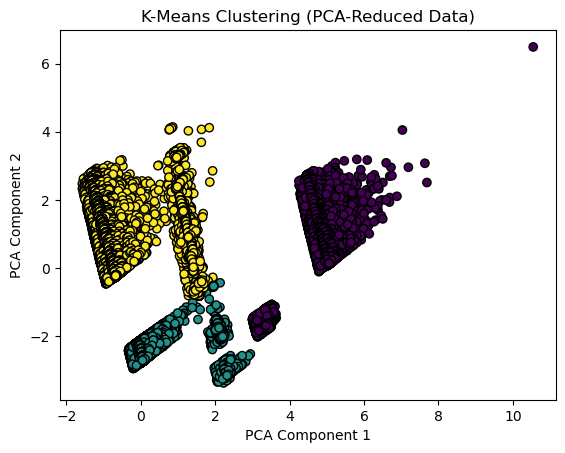

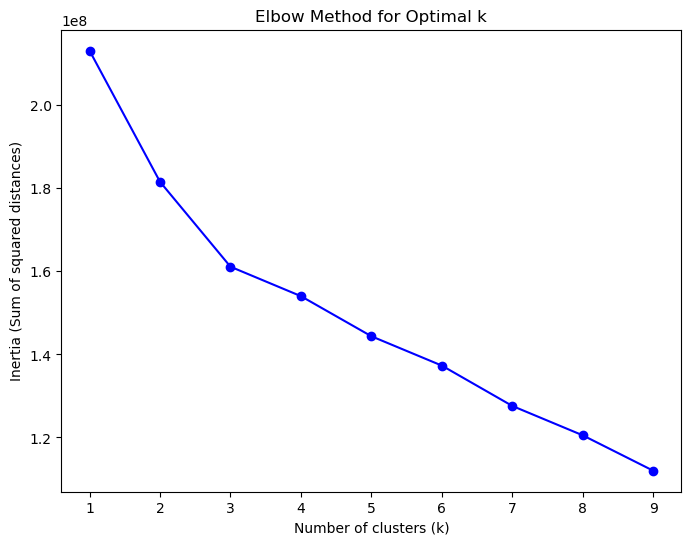

Centroids:
 [[-1.28604151e-02 -6.46025276e-03 -2.05764808e-02  8.02114348e-02
  -3.63355413e-01  1.68538373e-01 -4.08317410e-01 -4.08309840e-01
  -4.09286628e-01 -4.08076673e-01  2.44530199e+00 -4.07479816e-01
  -4.07318615e-01 -1.70933320e-03 -5.03911820e-03 -1.88566857e-03
   3.05722882e-03 -3.63905796e-01  2.14646153e-03  8.79360895e-03
  -3.63271013e-04  3.61901514e-01]
 [-2.55621973e-02  1.30156404e-03 -1.79477693e-02  7.09843303e-02
  -3.63355413e-01  1.76876178e-01 -4.08317410e-01 -4.08309840e-01
  -4.09286628e-01 -4.08076673e-01 -4.08947445e-01  2.45410929e+00
  -4.07318615e-01 -1.97021494e-03 -5.03911820e-03  2.37343245e-03
   3.76508023e-03 -3.63905796e-01 -1.44831949e-04  3.36789280e-04
   9.30594362e-04  3.62322868e-01]
 [ 1.33104396e-01  1.98023348e-02  1.45993753e-01 -5.82804380e-01
   2.74380781e+00 -1.29337471e+00  7.04449475e-04 -1.14895525e-03
  -7.37156765e-04  1.15034181e-03  4.33208917e-04  1.10970623e-03
  -1.51137002e-03 -3.04792833e-03 -5.03911820e-03 -4.4518077

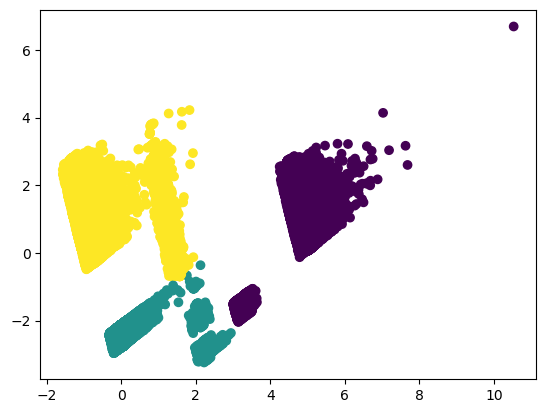

Cluster Centers:
 [[ 1.33104396e-01  1.98023348e-02  1.45993753e-01 -5.82804380e-01
   2.74380781e+00 -1.29337471e+00  7.04449475e-04 -1.14895525e-03
  -7.37156765e-04  1.15034181e-03  4.33208917e-04  1.10970623e-03
  -1.51137002e-03 -3.04792833e-03 -5.03911820e-03 -4.45180770e-03
  -2.06738796e-02  2.74796392e+00 -4.22579483e-03 -2.03414066e-02
  -9.99633621e-03 -2.73456744e+00]
 [ 1.00305170e+00 -1.38056391e-02 -3.53856607e-02  1.69805032e+00
  -3.63355413e-01 -1.29337471e+00 -2.67606357e-03 -5.13096214e-03
   2.68440172e-03  3.08056676e-03  1.78385605e-03 -3.94727542e-03
   4.20175676e-03 -8.09478320e-04 -5.03911820e-03 -2.46848179e-03
   5.42741582e-03 -3.63905796e-01 -4.22579483e-03  3.34045153e-02
   3.62749832e-04  3.60258778e-01]
 [-4.37070066e-01  1.97334316e-03 -1.27370427e-02 -5.88910700e-01
  -3.63355413e-01  7.73171142e-01  9.68091911e-04  2.32322673e-03
  -9.65407150e-04 -1.48088464e-03 -8.14012159e-04  1.41476958e-03
  -1.44429755e-03  9.02150679e-04  3.01235268e-03  1.8

In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Get cluster labels (which cluster each point belongs to)
labels = kmeans.labels_

from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering (PCA-Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

# Print the cluster centers (centroids)
centroids = kmeans.cluster_centers_
print("Centroids:\n", centroids)

# Assign cluster labels to the original data (optional)
df['Cluster'] = labels

# Look at the first few rows
print(df.head())

# Assuming df_transformed is the preprocessed data without 'Is Fraud?'
X = df_transformed.drop(columns=['Is Fraud?'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit K-Means and predict clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to your original dataset
df_transformed['Cluster'] = labels

# Optional: Visualize if you reduce it to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.show()

# Evaluate cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

In [ ]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
sil_score = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {sil_score}')

In [ ]:
from sklearn.metrics import adjusted_rand_score

# If you have ground truth labels (e.g., 'Is Fraud?')
ari_score = adjusted_rand_score(df_transformed['Is Fraud?'], labels)
print(f'Adjusted Rand Index: {ari_score}')

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Assuming you have true labels (e.g., 'Is Fraud?')
homogeneity = homogeneity_score(df_transformed['Is Fraud?'], labels)
completeness = completeness_score(df_transformed['Is Fraud?'], labels)
v_measure = v_measure_score(df_transformed['Is Fraud?'], labels)

print(f'Homogeneity: {homogeneity}, Completeness: {completeness}, V-Measure: {v_measure}')